In [ ]:
 !pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
import pickle
import numpy as np
from deepchem.feat.base_classes import MolecularFeaturizer
from rdkit.Chem import Descriptors, AllChem, MolFromSmiles
from rdkit import Chem
from rdkit import DataStructs
from deepchem.utils.typing import RDKitMol
import logging


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:
smiles = pd.read_excel('glass_tran_dataset.xlsx')
smiles_array = smiles['Name']
df = smiles.drop_duplicates(subset=['Name'])
print(smiles.shape)
df

(635, 18)


,Name,Formula,#CH3,#CH2,#CH,#C,#OH,#C-O-C,#O=C,DBA,#N,#Hal,O:C,M / g/mol,Tm / K,Tg / K,Tg/Tm,SMILES
0,glucose,C6H12O6,0,1,4,1,5,0,1,1,0,0,1.000000,180.0,419.00,303.0,0.723150,C(C1C(C(C(C(O1)O)O)O)O)O
6,dextrose,C6H12O6,0,1,4,1,5,0,1,1,0,0,1.000000,180.0,432.00,310.0,0.717593,C(C1C(C(C(C(O1)O)O)O)O)O
7,tartaric acid,C4H6O6,0,0,2,2,4,0,2,2,0,0,1.500000,150.0,430.00,291.0,0.676744,O=C(O)C(O)C(O)C(=O)O
8,"1,2,3-propanetricarboxylic acid",C6H8O6,0,2,1,3,3,0,3,3,0,0,1.000000,176.0,431.15,284.0,0.658703,C(C(CC(=O)O)C(=O)O)C(=O)O
9,"1,2,4-butanetricarboxylic acid",C7H10O6,0,3,1,3,3,0,3,3,0,0,0.857143,190.0,391.65,276.0,0.704711,C(CC(=O)O)C(CC(=O)O)C(=O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,Nilutamide,C12H10F3N3O4,2,0,3,7,0,0,4,7,3,3,0.333333,317.0,428.00,306.0,0.714953,CC1(C(=O)N(C(=O)N1)C2=CC(=C(C=C2)[N+](=O)[O-])...
631,Aceclofenac,C16H13Cl2NO4,0,2,7,7,1,1,2,10,1,2,0.250000,354.0,426.00,283.0,0.664319,C1=CC=C(C(=C1)CC(=O)OCC(=O)O)NC2=C(C=CC=C2Cl)Cl
632,Miconazole,C18H14Cl4N2O,0,2,10,6,0,1,0,11,2,4,0.055556,416.0,359.00,274.0,0.763231,C1=CC(=C(C=C1Cl)Cl)COC(CN2C=CN=C2)C3=C(C=C(C=C...
633,Flurbiprofen,C15H13FO2,1,0,9,5,1,0,1,9,0,1,0.133333,244.0,388.00,267.0,0.688144,CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)O


In [ ]:
smiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       635 non-null    object 
 1   Formula    635 non-null    object 
 2   #CH3       635 non-null    int64  
 3   #CH2       635 non-null    int64  
 4   #CH        635 non-null    int64  
 5   #C         635 non-null    int64  
 6   #OH        635 non-null    int64  
 7   #C-O-C     635 non-null    int64  
 8   #O=C       635 non-null    int64  
 9   DBA        635 non-null    int64  
 10  #N         635 non-null    int64  
 11  #Hal       635 non-null    int64  
 12  O:C        635 non-null    float64
 13  M / g/mol  635 non-null    float64
 14  Tm / K     635 non-null    float64
 15  Tg / K     635 non-null    float64
 16  Tg/Tm      635 non-null    float64
 17  SMILES     635 non-null    object 
dtypes: float64(5), int64(10), object(3)
memory usage: 89.4+ KB


In [ ]:
import numpy as np
from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

list_1 = np.array([])
for ids in smiles_array:
    list_1 = np.append(list_1, CIRconvert(ids))

list_1

array(['OC[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C=O',
       'OC[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C=O', 'OC(C(O)C(O)=O)C(O)=O',
       'OC(=O)CC(CC(O)=O)C(O)=O', 'OC(=O)CCC(CC(O)=O)C(O)=O', 'OCC(O)CO',
       'OC[C@@H](O)[C@@H](O)[C@@H](O)C=O',
       'OC[C@@H](O)[C@@H](O)[C@@H](O)C=O', 'CCO', 'CCCO', 'CO', 'OCCO',
       'Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4',
       'OCC(O)C(O)C(OC1OC(CO)C(O)C(O)C1O)C(O)CO',
       'CCC(=O)c1c(O)cc(O)cc1O', 'CC(C)CO', 'CCCCCCO', 'CCCCCO',
       'OCc1ccccc1', 'CC(O)CO', 'Oc1cccc(O)c1',
       '[O-]C(=O)c1ccccc1Oc2ccccc2', 'Oc1ccccc1C(=O)Oc2ccccc2',
       'COC(=O)c1ccccc1C(=O)OC', 'CCOC(=O)c1ccccc1C(=O)OCC',
       'CCCCC(CC)CO', 'CCC(C)CC(O)CC', 'OCCc1ccccc1', 'CCC(C)O',
       'CC(C)(C)CO', 'Cc1ccccc1C', 'Cc1cccc(C)c1', 'CCCC(C)C',
       'c1ccc(cc1)C=C(c2ccccc2)c3ccccc3', 'CCC=C', 'Cc1ccc(C=C)cc1',
       'c1ccc(cc1)c2ccccc2c3ccccc3', 'Cc1ccccc1', 'CCc1ccccc1',
       'CCCc1ccccc1', 'CCCCCc1ccccc1', 'CCCCCCc1ccccc1', 'CCC(C)c1ccccc1',
       'C

In [ ]:
# x = pd.DataFrame(list_1)
# x.columns = ['SMILES']
# smiles_x = pd.concat([smiles, x], axis=1)
df_2 = smiles.drop_duplicates(subset=['SMILES'])
df_2

,Name,Formula,#CH3,#CH2,#CH,#C,#OH,#C-O-C,#O=C,DBA,#N,#Hal,O:C,M / g/mol,Tm / K,Tg / K,Tg/Tm,SMILES
0,glucose,C6H12O6,0,1,4,1,5,0,1,1,0,0,1.000000,180.0,419.00,303.0,0.723150,C(C1C(C(C(C(O1)O)O)O)O)O
7,tartaric acid,C4H6O6,0,0,2,2,4,0,2,2,0,0,1.500000,150.0,430.00,291.0,0.676744,O=C(O)C(O)C(O)C(=O)O
8,"1,2,3-propanetricarboxylic acid",C6H8O6,0,2,1,3,3,0,3,3,0,0,1.000000,176.0,431.15,284.0,0.658703,C(C(CC(=O)O)C(=O)O)C(=O)O
9,"1,2,4-butanetricarboxylic acid",C7H10O6,0,3,1,3,3,0,3,3,0,0,0.857143,190.0,391.65,276.0,0.704711,C(CC(=O)O)C(CC(=O)O)C(=O)O
10,glycerol,C3H8O3,0,2,1,0,3,0,0,0,0,0,1.000000,92.0,291.00,180.0,0.618557,OCC(O)CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,Nilutamide,C12H10F3N3O4,2,0,3,7,0,0,4,7,3,3,0.333333,317.0,428.00,306.0,0.714953,CC1(C(=O)N(C(=O)N1)C2=CC(=C(C=C2)[N+](=O)[O-])...
631,Aceclofenac,C16H13Cl2NO4,0,2,7,7,1,1,2,10,1,2,0.250000,354.0,426.00,283.0,0.664319,C1=CC=C(C(=C1)CC(=O)OCC(=O)O)NC2=C(C=CC=C2Cl)Cl
632,Miconazole,C18H14Cl4N2O,0,2,10,6,0,1,0,11,2,4,0.055556,416.0,359.00,274.0,0.763231,C1=CC(=C(C=C1Cl)Cl)COC(CN2C=CN=C2)C3=C(C=C(C=C...
633,Flurbiprofen,C15H13FO2,1,0,9,5,1,0,1,9,0,1,0.133333,244.0,388.00,267.0,0.688144,CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)O


In [ ]:
# Specify the columns you want to check for duplicates
columns_to_check = ['#CH3', '#CH2', '#CH', '#C ', '#OH', '#C-O-C', '#O=C', 'DBA', '#N', '#Hal']  # Replace with your column names

# Drop duplicate rows based on the specified columns
df_3 = smiles.drop_duplicates(subset=columns_to_check)
df_3

,Name,Formula,#CH3,#CH2,#CH,#C,#OH,#C-O-C,#O=C,DBA,#N,#Hal,O:C,M / g/mol,Tm / K,Tg / K,Tg/Tm,SMILES
0,glucose,C6H12O6,0,1,4,1,5,0,1,1,0,0,1.000000,180.0,419.00,303.0,0.723150,C(C1C(C(C(C(O1)O)O)O)O)O
7,tartaric acid,C4H6O6,0,0,2,2,4,0,2,2,0,0,1.500000,150.0,430.00,291.0,0.676744,O=C(O)C(O)C(O)C(=O)O
8,"1,2,3-propanetricarboxylic acid",C6H8O6,0,2,1,3,3,0,3,3,0,0,1.000000,176.0,431.15,284.0,0.658703,C(C(CC(=O)O)C(=O)O)C(=O)O
9,"1,2,4-butanetricarboxylic acid",C7H10O6,0,3,1,3,3,0,3,3,0,0,0.857143,190.0,391.65,276.0,0.704711,C(CC(=O)O)C(CC(=O)O)C(=O)O
10,glycerol,C3H8O3,0,2,1,0,3,0,0,0,0,0,1.000000,92.0,291.00,180.0,0.618557,OCC(O)CO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,Nilutamide,C12H10F3N3O4,2,0,3,7,0,0,4,7,3,3,0.333333,317.0,428.00,306.0,0.714953,CC1(C(=O)N(C(=O)N1)C2=CC(=C(C=C2)[N+](=O)[O-])...
631,Aceclofenac,C16H13Cl2NO4,0,2,7,7,1,1,2,10,1,2,0.250000,354.0,426.00,283.0,0.664319,C1=CC=C(C(=C1)CC(=O)OCC(=O)O)NC2=C(C=CC=C2Cl)Cl
632,Miconazole,C18H14Cl4N2O,0,2,10,6,0,1,0,11,2,4,0.055556,416.0,359.00,274.0,0.763231,C1=CC(=C(C=C1Cl)Cl)COC(CN2C=CN=C2)C3=C(C=C(C=C...
633,Flurbiprofen,C15H13FO2,1,0,9,5,1,0,1,9,0,1,0.133333,244.0,388.00,267.0,0.688144,CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)O


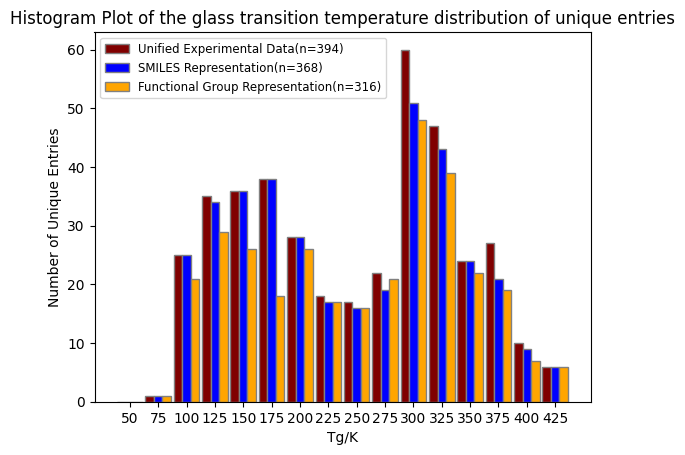

In [ ]:
import matplotlib.pyplot as plt

# Example molecular weights of molecules
glass_temp = df['Tg / K']
glass_temp_2 = df_2['Tg / K']
glass_temp_3 = df_3['Tg / K']

# Define categories and their corresponding ranges
categories = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425]
category_labels = ['<=50', '51-75', '76-100', '101-125', '126-150', '151-175', '176-200', '201-225', '226-250', '251-275', '276-300', '301-325', '326-350', '351-375', '376-400', '>400']


# Count the number of molecules falling into each category
category_counts = [0] * len(categories)
for weight in glass_temp:
    for i, cat in enumerate(categories):
        if weight <= cat:
            category_counts[i] += 1
            break

category_counts_2 = [0] * len(categories)
for weight in glass_temp_2:
    for i, cat in enumerate(categories):
        if weight <= cat:
            category_counts_2[i] += 1
            break

category_counts_3 = [0] * len(categories)
for weight in glass_temp_3:
    for i, cat in enumerate(categories):
        if weight <= cat:
            category_counts_3[i] += 1
            break

bar_width = 0.3
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]

# Create bar plot
plt.bar(r1, category_counts, color ='maroon',edgecolor='grey',  label='Unified Experimental Data(n=394)',
        width = bar_width)
plt.bar(r2, category_counts_2, color ='blue',edgecolor='grey', label = 'SMILES Representation(n=368)',
        width = bar_width)
plt.bar(r3, category_counts_3, color ='orange',edgecolor='grey', label = 'Functional Group Representation(n=316)',
        width = bar_width)

# Add title and labels
plt.title('Histogram Plot of the glass transition temperature distribution of unique entries')
plt.xlabel('Tg/K')
plt.ylabel('Number of Unique Entries')
# plt.xticks([r + bar_width for r in range(0, len(categories), 2)], categories)
visible_ticks = range(0, len(categories), 2)  # Setting every 2nd tick to be visible
plt.xticks(visible_ticks, [categories[i] for i in visible_ticks])
plt.xticks(np.arange(len(categories)) + bar_width , categories)
# Display the plot
plt.legend(loc='upper left',prop={'size': 8.5})
plt.show()


In [ ]:
y = pd.read_excel('updated_with_smile_values.xlsx')
y

,Name,Formula,#CH3,#CH2,#CH,#C,#OH,#C-O-C,#O=C,DBA,...,Tm/Tg,#S,#branching,SMILES,smiles_Tg,Boyer-Beaman Rule,Shiraiwa,Functional_Tg,mean - smile_Tg,mean - func_Tg
0,glucose,C6H12O6,0,1,4,1,5,0,1,1,...,1.395815,0,5,C(C1C(C(C(C(O1)O)O)O)O)O,275.289294,293.7725,391.710000,293.022560,26.0,8.0
1,dextrose,C6H12O6,0,1,4,1,5,0,1,1,...,1.393548,0,5,C(C1C(C(C(C(O1)O)O)O)O)O,272.585461,302.4000,391.710000,292.533215,38.0,18.0
2,tartaric acid,C4H6O6,0,0,2,2,4,0,2,2,...,1.489049,0,4,O=C(O)C(O)C(O)C(=O)O,287.347042,301.0000,384.030000,288.343042,2.0,1.0
3,"1,2,3-propanetricarboxylic acid",C6H8O6,0,2,1,3,3,0,3,3,...,1.559595,0,4,C(C(CC(=O)O)C(=O)O)C(=O)O,277.418084,301.8050,384.249200,282.200134,0.0,-5.0
4,"1,2,4-butanetricarboxylic acid",C7H10O6,0,3,1,3,3,0,3,3,...,1.435667,0,4,C(CC(=O)O)C(CC(=O)O)C(=O)O,274.659611,274.1550,398.610690,275.219444,-1.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,Nilutamide,C12H10F3N3O4,2,0,3,7,0,0,4,7,...,1.398693,0,10,NaN,NaN,299.6000,645.312895,NaN,NaN,NaN
395,Aceclofenac,C16H13Cl2NO4,0,2,7,7,1,1,2,10,...,1.505300,0,14,NaN,NaN,298.2000,736.732200,NaN,NaN,NaN
396,Miconazole,C18H14Cl4N2O,0,2,10,6,0,1,0,11,...,1.310219,0,16,NaN,NaN,251.3000,902.308640,NaN,NaN,NaN
397,Flurbiprofen,C15H13FO2,1,0,9,5,1,0,1,9,...,1.453184,0,14,NaN,NaN,271.6000,457.465520,NaN,NaN,NaN


In [ ]:
first_20 = y.iloc[:19]
first_20

,Name,Formula,#CH3,#CH2,#CH,#C,#OH,#C-O-C,#O=C,DBA,...,Tm/Tg,#S,#branching,SMILES,smiles_Tg,Boyer-Beaman Rule,Shiraiwa,Functional_Tg,mean - smile_Tg,mean - func_Tg
0,glucose,C6H12O6,0,1,4,1,5,0,1,1,...,1.395815,0,5,C(C1C(C(C(C(O1)O)O)O)O)O,275.289294,293.772500,391.71000,293.022560,26.0,8.0
1,dextrose,C6H12O6,0,1,4,1,5,0,1,1,...,1.393548,0,5,C(C1C(C(C(C(O1)O)O)O)O)O,272.585461,302.400000,391.71000,292.533215,38.0,18.0
2,tartaric acid,C4H6O6,0,0,2,2,4,0,2,2,...,1.489049,0,4,O=C(O)C(O)C(O)C(=O)O,287.347042,301.000000,384.03000,288.343042,2.0,1.0
3,"1,2,3-propanetricarboxylic acid",C6H8O6,0,2,1,3,3,0,3,3,...,1.559595,0,4,C(C(CC(=O)O)C(=O)O)C(=O)O,277.418084,301.805000,384.24920,282.200134,0.0,-5.0
4,"1,2,4-butanetricarboxylic acid",C7H10O6,0,3,1,3,3,0,3,3,...,1.435667,0,4,C(CC(=O)O)C(CC(=O)O)C(=O)O,274.659611,274.155000,398.61069,275.219444,-1.0,-2.0
5,glycerol,C3H8O3,0,2,1,0,3,0,0,0,...,1.564822,0,1,OCC(O)CO,187.424421,203.904167,240.13880,198.675696,-1.0,-12.0
6,ribose,C5H10O5,0,1,3,1,5,0,1,1,...,1.390746,0,4,C1C(C(C(C(O1)O)O)O)O,266.045851,252.466667,383.81520,274.502699,-6.0,-15.0
7,ethanol,C2H6O,1,1,0,0,1,0,0,0,...,1.671080,0,0,OCC,96.762616,111.770167,111.43720,97.871420,-1.0,-2.0
8,n-propanol,C3H8O,1,2,0,0,1,0,0,0,...,1.516545,0,0,CCCO,97.572654,103.580000,113.94612,97.201627,0.0,1.0
9,methanol,CH4O,1,0,0,0,1,0,0,0,...,1.718560,0,0,CO,101.733020,122.825500,151.89080,103.737842,1.0,-1.0


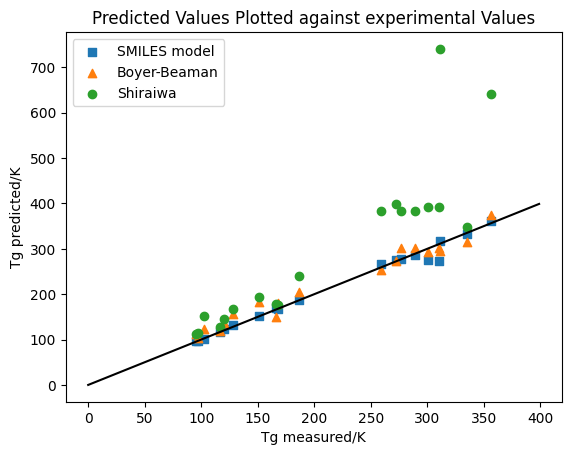

In [ ]:
z = range(0, 400)

# Calculate y values (y = x)
y = [val for val in z]

plt.plot(z,y, color='black')
plt.scatter(first_20['Tg / K'], first_20['smiles_Tg'], marker = "s",label='SMILES model')
plt.scatter(first_20['Tg / K'], first_20['Boyer-Beaman Rule'], marker = "^",label='Boyer-Beaman')
plt.scatter(first_20['Tg / K'], first_20['Shiraiwa'], label='Shiraiwa')


# Add labels and title
plt.xlabel('Tg measured/K')
plt.ylabel('Tg predicted/K')
plt.title('Predicted Values Plotted against experimental Values')

# Show plot
plt.legend()
plt.show()

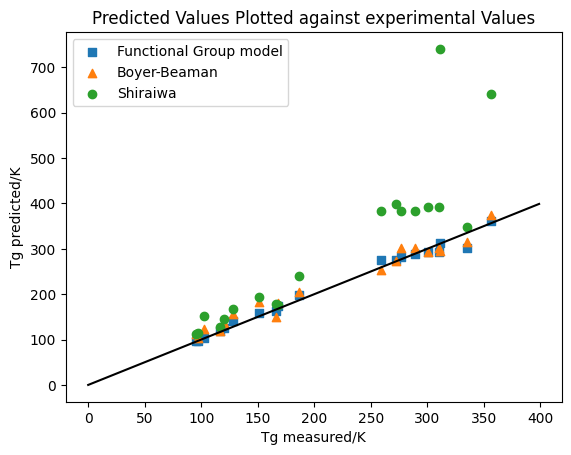

In [ ]:
z = range(0, 400)

# Calculate y values (y = x)
y = [val for val in z]

plt.plot(z,y, color='black')
plt.scatter(first_20['Tg / K'], first_20['Functional_Tg'], marker = "s",label='Functional Group model')
plt.scatter(first_20['Tg / K'], first_20['Boyer-Beaman Rule'], marker = "^",label='Boyer-Beaman')
plt.scatter(first_20['Tg / K'], first_20['Shiraiwa'], label='Shiraiwa')


# Add labels and title
plt.xlabel('Tg measured/K')
plt.ylabel('Tg predicted/K')
plt.title('Predicted Values Plotted against experimental Values')

# Show plot
plt.legend()
plt.show()

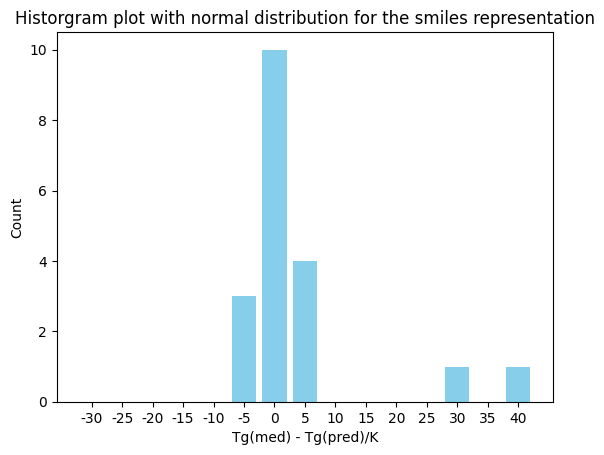

In [ ]:
import matplotlib.pyplot as plt

# Example molecular weights of molecules
molecular_weights = first_20['mean - Tg']

# Define categories and their corresponding ranges
categories = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]

# Count the number of molecules falling into each category
category_counts = [0] * len(categories)
for weight in molecular_weights:
    for i, cat in enumerate(categories):
        if weight <= cat:
            category_counts[i] += 1
            break

r1 = range(len(categories))

# Create bar plot
plt.bar(r1, category_counts, color='skyblue', label = 'Smiles Representation')

# Add title and labels
plt.title('Historgram plot with normal distribution for the smiles representation')
plt.xlabel('Tg(med) - Tg(pred)/K')
plt.ylabel('Count')

visible_ticks = range(0, len(categories), 2)  # Setting every 2nd tick to be visible
plt.xticks(visible_ticks, [categories[i] for i in visible_ticks])
plt.xticks(np.arange(len(categories)), categories)
# Display the plot
plt.show()


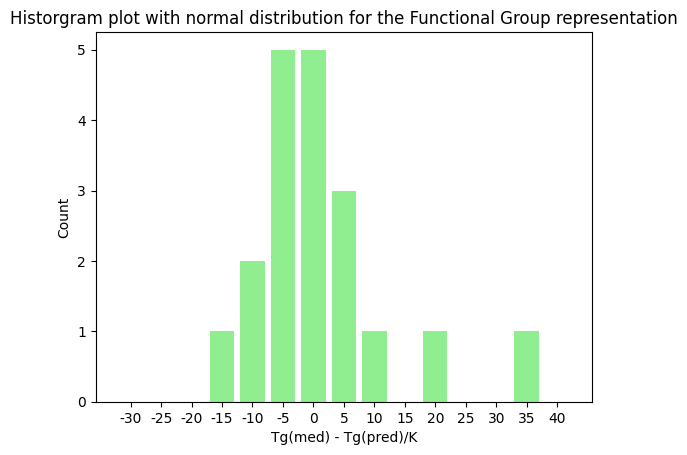

In [ ]:
import matplotlib.pyplot as plt

# Example molecular weights of molecules
molecular_weights = first_20['mean - func_Tg']

# Define categories and their corresponding ranges
categories = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]

# Count the number of molecules falling into each category
category_counts = [0] * len(categories)
for weight in molecular_weights:
    for i, cat in enumerate(categories):
        if weight <= cat:
            category_counts[i] += 1
            break

r1 = range(len(categories))

# Create bar plot
plt.bar(r1, category_counts, color='lightgreen', label = 'Smiles Representation')

# Add title and labels
plt.title('Historgram plot with normal distribution for the Functional Group representation')
plt.xlabel('Tg(med) - Tg(pred)/K')
plt.ylabel('Count')

visible_ticks = range(0, len(categories), 2)  # Setting every 2nd tick to be visible
plt.xticks(visible_ticks, [categories[i] for i in visible_ticks])
plt.xticks(np.arange(len(categories)), categories)
# Display the plot
plt.show()


In [ ]:
def count_branches(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES"

    mol = Chem.AddHs(mol)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    connectivity = {i: [] for i in range(len(atoms))}

    for bond in bonds:
        begin_atom_idx = bond.GetBeginAtomIdx()
        end_atom_idx = bond.GetEndAtomIdx()
        connectivity[begin_atom_idx].append(end_atom_idx)
        connectivity[end_atom_idx].append(begin_atom_idx)

    branch_count = 0
    for atom_idx, connected_atoms in connectivity.items():
        if len(connected_atoms) > 1:
            branch_count += 1

    return branch_count


In [ ]:
vectorized_count_branches = np.vectorize(count_branches)

# Calculate branch counts for all molecules in the array
branch_counts = vectorized_count_branches(smiles_array)

print("Branch counts:", branch_counts)

In [ ]:
result=np.concatenate((smiles_array,branch_counts),axis=1)
result_df=pd.DataFrame(result,columns=['smiles','no.of branches'])
result_df

In [ ]:
result_df.to_csv('result.csv',index=False)